In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

In [ ]:
!unzip data.zip


In [ ]:
df = pd.read_csv('data/train.csv')

In [ ]:
y = df['labels']

In [ ]:
df.shape

(514869, 24)

In [ ]:
y.shape

(514869,)

In [ ]:
train_data, test_data, train_labels, test_labels = train_test_split(
    df, y, test_size=0.3, random_state=21
)

In [ ]:
#Tried smote as well for imbalance check, but no improvement
#from imblearn.over_sampling import SMOTE
#smt = SMOTE()
#train_data,train_labels = smt.fit_resample(train_data,train_labels)


In [ ]:
train_labels.value_counts()

1    283931
0    283931
Name: AOR Result, dtype: int64

In [ ]:
for column in train_data.columns:
  max_val = np.array(train_data[column]).max()
  min_val = np.array(train_data[column]).min()
  col = np.array(train_data[column])
  train_data[column] = (col - min_val)/(max_val - min_val)




In [ ]:
for column in test_data.columns:
  max_val = np.array(test_data[column]).max()
  min_val = np.array(test_data[column]).min()
  col = np.array(test_data[column])
  test_data[column] = (col - min_val)/(max_val - min_val)


In [ ]:
train_data.shape

(567862, 24)

In [ ]:
test_data.shape

(154461, 24)

In [ ]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

In [ ]:
normal_train_data.shape

(283931, 24)

### Build the Model

In [ ]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(12, activation="relu"),
      layers.Dense(6, activation="relu"),
      layers.Dense(3, activation="relu")])
    
    self.decoder = tf.keras.Sequential([
      layers.Dense(6, activation="relu"),
      layers.Dense(12, activation="relu"),
      layers.Dense(24, activation="sigmoid")])
    
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

In [ ]:
autoencoder.compile(optimizer='adam', loss='mae')

In [ ]:
history = autoencoder.fit(normal_train_data, normal_train_data, 
          epochs=100, 
          batch_size=512,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/100
555/555 [==============================] - 4s 5ms/step - loss: 0.1548 - val_loss: 0.1133
Epoch 2/100
555/555 [==============================] - 2s 3ms/step - loss: 0.1047 - val_loss: 0.1006
Epoch 3/100
555/555 [==============================] - 2s 3ms/step - loss: 0.1012 - val_loss: 0.1005
Epoch 4/100
555/555 [==============================] - 2s 3ms/step - loss: 0.1009 - val_loss: 0.1000
Epoch 5/100
555/555 [==============================] - 2s 3ms/step - loss: 0.1002 - val_loss: 0.0971
Epoch 6/100
555/555 [==============================] - 2s 3ms/step - loss: 0.0861 - val_loss: 0.0810
Epoch 7/100
555/555 [==============================] - 2s 4ms/step - loss: 0.0779 - val_loss: 0.0764
Epoch 8/100
555/555 [==============================] - 2s 3ms/step - loss: 0.0751 - val_loss: 0.0749
Epoch 9/100
555/555 [==============================] - 2s 3ms/step - loss: 0.0738 - val_loss: 0.0741
Epoch 10/100
555/555 [==============================] - 2s 3ms/step - loss: 0.0730 - val_lo

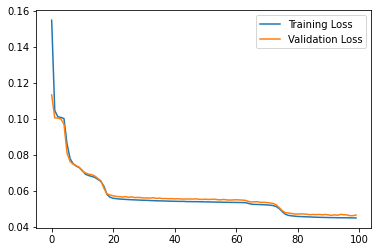

In [ ]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

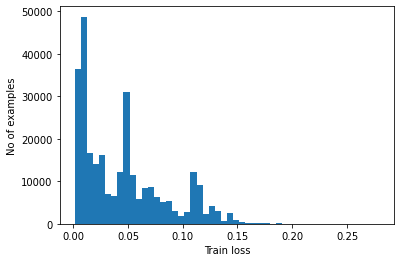

In [ ]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

### Set threshold for comparison of anomaly

In [ ]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.08423802224563953


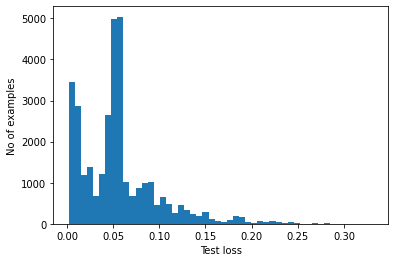

In [ ]:
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

In [ ]:
np.mean(test_loss) + np.std(test_loss)

0.09868523345017208

In [ ]:
def predict(model, data, threshold):
  reconstructions = model.predict(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

### Check the train statistics

In [ ]:
preds_train = predict(autoencoder, train_data, threshold)


In [ ]:
print_stats(preds_train, train_labels)

Accuracy = 0.5135525884810042
Precision = 0.5083855249451934
Recall = 0.8216468085555998


In [ ]:
confusion_matrix(preds_train, train_labels)

array([[ 58336,  50640],
       [225595, 233291]])

### Check the test statistics

In [ ]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Accuracy = 0.694557202141641
Precision = 0.793118593288001
Recall = 0.8293965192001705


In [ ]:

confusion_matrix(test_labels, preds)

array([[  6157,  26378],
       [ 20801, 101125]])